# ISSM "square ice shelf" tutorial

This script reproduces ISSM's square ice shelf tutorial, but avoiding the use of any of the pre-written scripts or files. Unlike the original tutorial, we mesh the domain ourselves, specify the geometry, and manually identify boundaries and apply boundary conditions. We plot the resulting velocity field using matplotlib. 

## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt

######################
### ISSM functions ###
######################

from model import model
from setmask import setmask
from setflowequation import setflowequation
from solve import solve
from plotmodel import plotmodel
from cuffey import cuffey #calculates flow parameter B from temperature
from squaremesh import squaremesh

OSGeo/GDAL for Python not installed, overlay plots are not enabled


## Initialize model and mesh domain

In [2]:
md = model()
md = squaremesh(md, 1e6, 1e6, 20, 20) #squaremesh(model, x, y, nx, ny)
md = setflowequation(md, 'SSA', 'all')

## Describe boundaries and levelsets

ISSM needs to know which parts of the domain are grounded ice, floating ice, terminus boundary, and ocean. Additionally, it will be useful to set up distinct boundary subsets (terminus, sidewalls, and inflow boundary). 

In [3]:
x, y = md.mesh.x, md.mesh.y
x_max, x_min, y_max, y_min = x.max(), x.min(), y.max(), y.min()

########################################
### describe the boundary components ###
########################################

Γ_terminus = (x == x_max) #choose the terminus to lie on the rightmost boundary
Γ_inflow = (x == x_min) #inflow boundary on the leftmost boundary
Γ_sidewalls = (y == y_max) | (y == y_min) #sidewalls on the upper and lower boundaries

##############################
### describe the levelsets ###
##############################

md.mask.ice_levelset = -1*np.ones_like(x) #ice is floating where md.mask.ice_levelset < 0 (grounded where > 0)
md.mask.ice_levelset[Γ_terminus] = 0 #the glacier terminus is where md.mask.ice_levelset == 0
md.mask.ocean_levelset = -1*np.ones_like(x) #ocean exists where md.mask.ocean_levelset < 0 

## Material parameters and initial configuration

In [4]:
##########################
### material densities ###
##########################

ρ_i = md.materials.rho_ice
ρ_w = md.materials.rho_water
ϱ = ρ_i/ρ_w

########################
### initial geometry ###
########################

H_min = 300
H_max = 1000
H = H_max + (H_min - H_max)*(x - x_min)/(x_max - x_min)
s = (1 - ϱ)*H
b = s - H
md.geometry.thickness = H
md.geometry.base = b
md.geometry.surface = s

######################
### basal friction ###
######################

num_e = md.mesh.numberofelements
md.friction.coefficient = np.zeros((num_e)) #these don't really matter
md.friction.p = np.ones((num_e)) #since all our ice is floating
md.friction.q = np.ones((num_e)) #but they still need to be initialized

################
### rheology ###
################

temp_C = -20
md.materials.rheology_B = cuffey((273 + temp_C)*np.ones_like(x))

## Set boundary conditions

Set velocity boundary conditions in $x$ and $y$ using ```md.stressbalance.spcvx``` and ```md.stressbalance.spcvy```.

/home/mielebzu/ISSM/src/m/plot/plotmodel.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


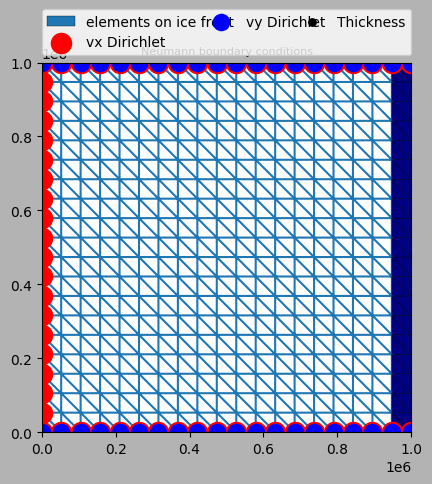

In [5]:
md.stressbalance.spcvx = np.nan*np.ones_like(x) #initialize single-point constraints (SPCs) on vx and vy
md.stressbalance.spcvy = np.nan*np.ones_like(x) #wherever these remain nans, the model assumes an ice front

md.stressbalance.spcvx[Γ_inflow] = 0. 
md.stressbalance.spcvx[Γ_sidewalls] = 0.
md.stressbalance.spcvy[Γ_sidewalls] = 0.

plotmodel(md, 'data', 'BC') #plot the boundary conditions

## Additional specifications

A few extra things we need to set before the model will run... mostly unclear why. 

In [6]:
md.stressbalance.referential = np.nan*np.ones((len(x), 6))
md.stressbalance.loadingforce = np.zeros((len(x), 3))
md.miscellaneous.name = 'name'

## And solve!

In [7]:
md = solve(md, 'Stressbalance')
# plotmodel(md, 'data', md.results.StressbalanceSolution.Vel)

checking model consistency
marshalling file 'name'.bin
uploading input file and queuing script
launching solution sequence on remote cluster

──────────────────────────────────────────────────────────────────────
Ice-sheet and Sea-level System Model (ISSM) version 2026.1
          GitHub: https://github.com/ISSMteam/ISSM/
   Documentation: https://issmteam.github.io/ISSM-Documentation/
──────────────────────────────────────────────────────────────────────
call computational core:
   computing new velocity
write lock file:

   FemModel initialization elapsed time:   0.00913919
   Total Core solution elapsed time:       0.103364
   Linear solver elapsed time:             0.0403762 (39%)

   Total elapsed time: 0 hrs 0 min 0 sec
loading results from cluster


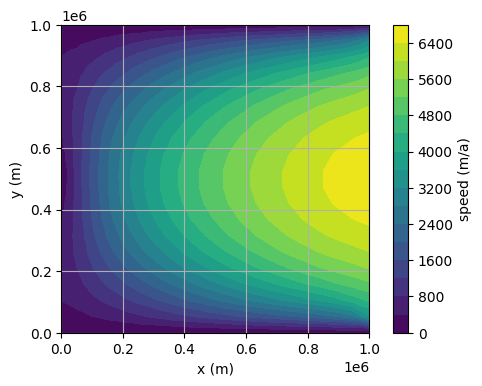

In [8]:
elts = md.mesh.elements - 1
speed = np.asarray(md.results.StressbalanceSolution.Vel).flatten()

plt.figure(figsize = (6, 4))
plt.tricontourf(x, y, elts, speed, levels = 20)
plt.colorbar(label = 'speed (m/a)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()